In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import requests
from selenium import webdriver
from war

In [ ]:
df_train = pd.read_csv('./train_data.csv')
df_test = pd.read_csv('./test_data.csv')

In [6]:
### Convert to int16 to save memory
df_train['overall'] = df_train['overall'].astype('int16') 
### Convert to datetime type
df_train['reviewTime'] =  pd.to_datetime(df_train['reviewTime'])
df_test['reviewTime'] =  pd.to_datetime(df_test['reviewTime'])
### Drop few rows so that data becomes cleaner (This is a minor change.)
df_train = df_train.dropna(subset=['summary', 'reviewerName'])
### Sort by datetime (reviewTime column)
df_train.sort_values(by='reviewTime', axis=0, inplace=True, ascending=True)
### Max and Min date range
print(f"Max date : {df_train['reviewTime'].max()}")
print(f"Min date : {df_train['reviewTime'].min()}")

### Convert vote column
df_train['vote'] = pd.to_numeric(df_train['vote'], errors='coerce', downcast='integer')
df_train['vote'] = df_train['vote'].fillna(pd.NA).astype('Int32')

Max date : 2018-10-03 00:00:00
Min date : 2016-01-01 00:00:00


<div style="direction:rtl; font-size: 25px; background-color: cyan; color:black; padding:30px 0"> بخش ۱) تجزیه و تحلیل اولیه از داده‌ها </div>

<div style="direction:rtl; font-size: 25px; background-color: green; color:black;"> قسمت اول </div>

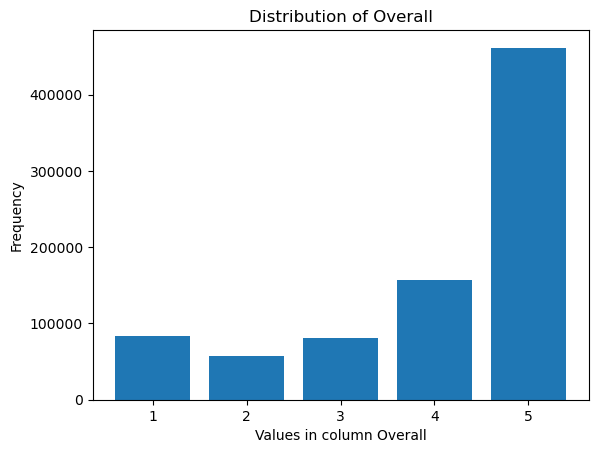

In [7]:
### Plot distrubution of overall column 
overall_values = df_train['overall'].value_counts().sort_index(ascending=False)
plt.xlabel('Values in column Overall')
plt.ylabel('Frequency')
plt.title('Distribution of Overall')
plt.bar(overall_values.index, overall_values.values)
plt.show()

In [8]:
df_train.head(10)

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime
346981,5,<NA>,True,2016-01-01,A1TNXXRSUAJVTE,B00OF8ME52,NaN,Dariusz Grabowski,not perfect but good enough to buy next time\n...,Five star,1451606400
509103,3,<NA>,True,2016-01-01,A2BYUPM1U28I4G,B013DY30HE,{'Color:': ' Black'},Rose,For the price you will get this kind of tablet...,Not that great tablet especially the camera bu...,1451606400
462655,5,<NA>,True,2016-01-01,A3K7EVFWNBX8DY,B00YNEIAWY,{'Style:': ' GTX 980 Ti AMP! Extreme'},Zewhyx,"Once all the drivers are installed, this thing...","Amazing Graphics Card, Sags in Port",1451606400
457844,5,<NA>,True,2016-01-01,A27TUANAY4CQCZ,B00Y3IGB62,NaN,Y. Hegazi,Using it to make my kvm switch setup universal...,I use it to make my hdmi kvm solution universa...,1451606400
469257,5,<NA>,True,2016-01-01,A2HCNLO9C6UFTK,B00ZDUQUJC,{'Package Quantity:': ' 2'},Zapper,These work great. and do exactly what they're ...,Does what it's supposed to do,1451606400
20192,5,18,True,2016-01-01,A12034ZBKBKK0A,B000ESCAUQ,NaN,J. Alfred,A great option for any 7 foot parabolic umbrel...,Great addition to a great modifier...,1451606400
20188,5,2,True,2016-01-01,A10AQMEFDTT7J5,B000ERAIW4,NaN,Paula Johnson,My 4-year old son loves his new Educational In...,Nice binoculars for kids!,1451606400
543297,2,<NA>,False,2016-01-01,A22I68UE2EV00S,B015JIAB7E,"{'Color:': ' White', 'Style:': ' Base'}",Darth Troglodyte,I was super excited to get my wife this camera...,Buyer beware... not all Snaps are created equa...,1451606400
497045,5,24,True,2016-01-01,AR7ELOK5FZIQR,B01265BGO0,"{'Size:': ' DVR', 'Color:': ' Car DVR'}",Dwight Stephens,I bought this as insurance. I am a ride share ...,"UBER & Lyft Drivers, this is a must have at th...",1451606400
148413,5,<NA>,True,2016-01-01,ADJBG8T60500,B009ISU33E,{'Style:': ' With Beam Forming Microphone'},A. Eassa,"With a good pair of headphones, there is a wor...",Great improvement over on-board audio.,1451606400


In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 838641 entries, 346981 to 838695
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   overall         838641 non-null  int16         
 1   vote            191372 non-null  Int32         
 2   verified        838641 non-null  bool          
 3   reviewTime      838641 non-null  datetime64[ns]
 4   reviewerID      838641 non-null  object        
 5   asin            838641 non-null  object        
 6   style           490444 non-null  object        
 7   reviewerName    838641 non-null  object        
 8   reviewText      838641 non-null  object        
 9   summary         838641 non-null  object        
 10  unixReviewTime  838641 non-null  int64         
dtypes: Int32(1), bool(1), datetime64[ns](1), int16(1), int64(1), object(6)
memory usage: 64.0+ MB


In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   vote            4933 non-null   float64       
 1   verified        20000 non-null  bool          
 2   reviewTime      20000 non-null  datetime64[ns]
 3   reviewerID      20000 non-null  object        
 4   asin            20000 non-null  object        
 5   style           11504 non-null  object        
 6   reviewerName    19996 non-null  object        
 7   reviewText      20000 non-null  object        
 8   summary         19998 non-null  object        
 9   unixReviewTime  20000 non-null  int64         
dtypes: bool(1), datetime64[ns](1), float64(1), int64(1), object(6)
memory usage: 1.4+ MB


<div style="direction:rtl; font-size: 25px; background-color: green; color:black;"> قسمت دوم </div>

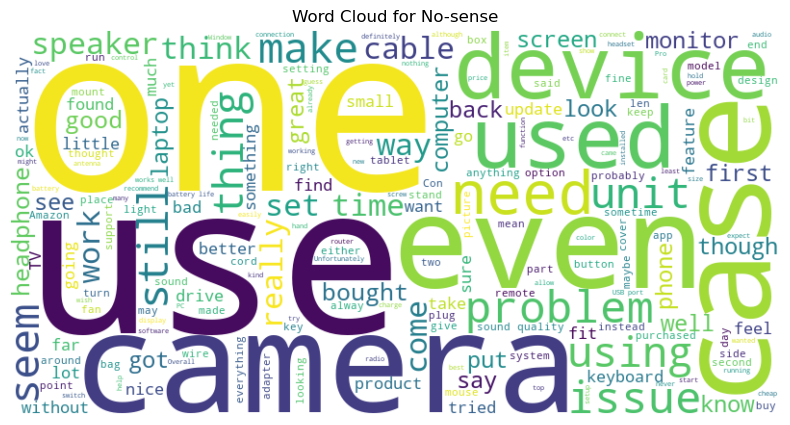

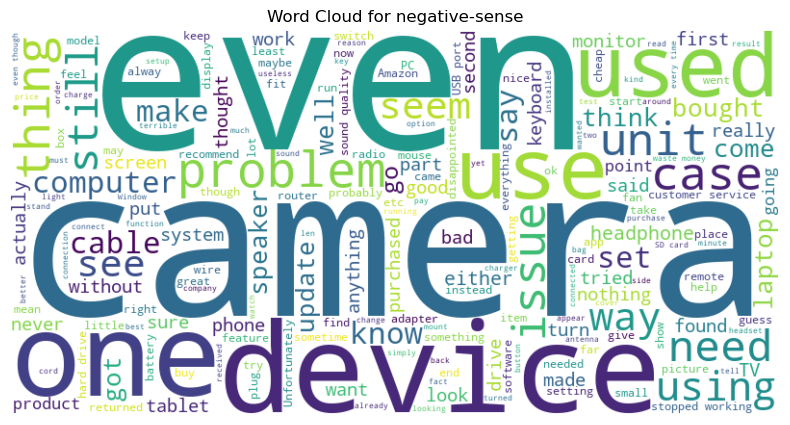

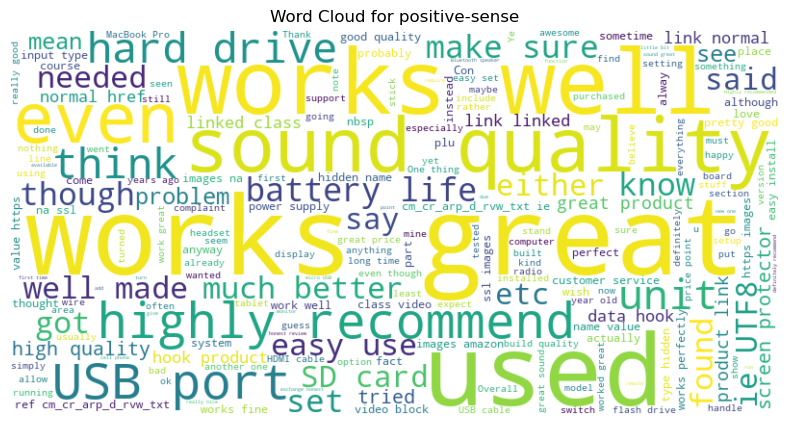

In [11]:
### You only need to run this once . Uncomment it again afterwards.
# nltk.download('stopwords')

### Define 3 groups
group_labels = {
    4: 'positive-sense',
    5: 'positive-sense',
    3: 'No-sense',
    2: 'negative-sense',
    1: 'negative-sense'
}
### Create a copy just to be sure
df_cloud = df_train.copy()

### Filter the DataFrame based on the custom group labels
df_cloud['group'] = df_cloud['overall'].map(group_labels)

### Just to be sure of results
### Filter out rows with no valid group
df = df_cloud[df_cloud['group'].notna()]

### Define a function to remove stop words from text string
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

### Apply remove_stopwords method to reviewText column
df_cloud['reviewText'] = df_cloud['reviewText'].apply(remove_stopwords)

### Plot word CLoud for each group
for group, data in df_cloud.groupby('group'):
    text = ' '.join(data['reviewText'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {group}')
    plt.axis('off')
    plt.show()

<div style="direction:rtl; font-size: 25px; background-color: green; color:black;"> قسمت سوم </div>

In [12]:
top_10_votes = df_train.sort_values(by='vote', ascending=False)
top_10_votes[['reviewerName', 'vote']].head(10)

,reviewerName,vote
561262,David H,982
521251,VermontGuy,971
537656,Chris Upton,970
137082,Chip Ahoy,923
173550,Tech Dude,920
703727,R. Voorhees,919
711265,Patrick,912
264627,Obi Wan,909
622020,Benson Leung,889
648021,Apollo Clark,833


<div style="direction:rtl; font-size: 25px; background-color: green; color:black;"> قسمت چهارم </div>

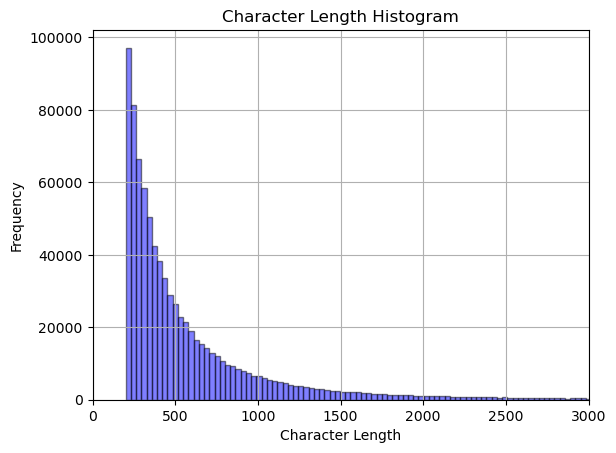

In [13]:
### Calculate bins using square root
num_bins = int(np.sqrt(len(df['reviewText'])))
### Plot
plt.hist(df['reviewText'].apply(len), bins=num_bins, alpha=0.5, color='b', edgecolor='black')
plt.title('Character Length Histogram')
plt.xlabel('Character Length')
plt.ylabel('Frequency')

### Limit x-axis
plt.xlim(0, 3000)

plt.grid(True)
plt.show()

<div style="direction:rtl; font-size: 25px; background-color: green; color:white;"> با توجه به نمودار هستوگرام بدست امده ، پیشنهاد میشود محدودیت ۲۰۰۰ تایی برای تعداد کاراکترهای نظرات در نظر گرفته شود چراکه اکثریت نظرات کمتر از این تعداد کاراکتر داشتند.  </div>

<div style="direction:rtl; font-size: 25px; background-color: green; color:black;"> قسمت پنجم </div>

In [14]:
### Groupby product string ID
top_products = df_train[df_train['overall'] == 5].groupby('asin').size().reset_index(name='count')
### Sort them by their count 
top_products = top_products.sort_values(by='count', ascending=False)
top_10_products = top_products[:10].reset_index(drop=True)
top_10_products

,asin,count
0,B010OYASRG,1162
1,B00L0YLRUW,659
2,B01DA0YCNC,600
3,B000VS4HDM,598
4,B0043T7FXE,552
5,B00OBRE5UE,529
6,B00S9SGNNS,471
7,B000WYVBR0,448
8,B00P7EVST6,433
9,B00OAJ412U,431


In [27]:
# from time import sleep

# for product_id in top_10_products["asin"]:
#     print(product_id)
#     path = f"https://www.amazon.com/dp/{product_id}"

#     response = requests.get(path)
#     print(f"response code is : {response.status_code}\n")
#     sleep(1)
#     if response.status_code == 200:
#         soup = BeautifulSoup(response.text, "html.parser")
#         print(soup.prettify())
#         # text_to_find = "Brand"
#         # element = soup.find(lambda tag: tag.name == 'span' and tag.get_text() == text_to_find)
#         element = soup.find('span', id='productTitle')
#         if element:

#             # next_sibling = element.find_next_sibling()
    
#             # if next_sibling:
#             #     sibling_inner_text = next_sibling.get_text()
#             #     print("Siblings Inner Text:", sibling_inner_text)
#             # else:
#             #     print("No next sibling found")
#             print(element)
#         else:
#             print("Element not found")
#     else:
#         print("Failed to retrieve the webpage")

B010OYASRG
response code is : 503

Failed to retrieve the webpage
B00L0YLRUW
response code is : 503

Failed to retrieve the webpage
B01DA0YCNC
response code is : 200

<!--
        To discuss automated access to Amazon data please contact api-services-support@amazon.com.
        For information about migrating to our APIs refer to our Marketplace APIs at https://developer.amazonservices.com/ref=rm_5_sv, or our Product Advertising API at https://affiliate-program.amazon.com/gp/advertising/api/detail/main.html/ref=rm_5_ac for advertising use cases.
-->
<!DOCTYPE html>
<html>
 <head>
  <meta charset="utf-8"/>
  <meta content="ie=edge" http-equiv="x-ua-compatible"/>
  <meta content="width=device-width, initial-scale=1, shrink-to-fit=no" name="viewport"/>
  <title>
   Sorry! Something went wrong!
  </title>
  <style>
   html, body {
    padding: 0;
    margin: 0
  }

  img {
    border: 0
  }

  #a {
    background: #232f3e;
    padding: 11px 11px 11px 192px
  }

  #b {
    position: absolut

In [ ]:

chrome_driver_path = '/usr/local/bin/chromedriver'

driver = webdriver.Chrome()

for product_id in top_10_products["asin"]:
    driver.get(f"https://www.amazon.com/dp/{product_id}")

    product_title_element = driver.find_element_by_id('productTitle')

    product_title = product_title_element.text

    print("Product Title:", product_title)

    driver.quit()